# 目录

- LDA主题模型
- Word2Vec
- GPT模型
- 使用爬虫批量下载年报
- 使用文本分析提取年报信息（MD&A）

# 1 LDA主题模型

## 1.1 基于词频的词袋法存在以下局限

1.维度灾难，独热表示法把每个词语看做一个维度，会导致向量非常稀疏，增加计算的复杂的和对存储空间的需求

2.无法表达同义词，近义词。同义词，近义词的向量表示应该是相关的，而独热表示法无法表示这种相关性

3.缺乏语境的信息，简单的词频表示无法捕捉到复杂的语境和语义。

## 1.2 LDA模型的核心思想

- 根据每个文档中的词语统计信息，从而推断该文档中所包含的主题分布和每个主题的词语分布
- 基本假设为：**每个文档由多个主题组成，每个主题由多个单词决定**

## 1.3 主题的概念

- 主题是文本数据中隐含的，潜在的语义结构，表示文档或词语类型或话题

- 主题表示一系列相关词语的集合

- 主题是词语的条件概率分布

- 主题也是文章的条件概率分布，例如文档“美国对伊朗再度实施单边制裁，这将对伊朗的进出口贸易造成严重影响”。可以假设这篇文档属于政治主题的概率是0.7，经济主题是0.2，其他主题合计为0.1

![主题模型.png](主题模型.png)

## 1.4 LDA主题模型的优势

1.降维。假设某个文档包含1000个不同词汇，使用基于词频的方法，该文档就会被表示为1000维的向量。但如果该文档由50个主题组合而成，则可以将这个文档映射成一个50维的向量。

2.考虑同义词，近义词。这类词语会有更高概率属于同一主题，向量表示接近。

3.解决多义词的问题。

4.对文档进行聚类。

5.可以排除文档中噪音的干扰。噪音往往除以次要的主题中。

## 1.5 LDA模型的输入和输出

输入包括经过分词后，文档的词向量，词典，主题的数量，迭代次数和其他超参数

输出主要包括文档的主题分布

## 1.6 LDA模型实操作代码，从期刊论文的标题，关键词和摘要中提取主题

In [4]:
# 数据导入
import pandas as pd 
import numpy as np
import re 
import os 
import time
from tqdm import tqdm
import jieba
import jieba.analyse
import gensim 
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
from collections import defaultdict
from cntext.dictionary import STOPWORDS_zh
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd 
from gensim.models.coherencemodel import CoherenceModel
import ast
import warnings
warnings.filterwarnings("ignore")

# 设置文件夹目录
os.chdir('D:/aSchool/aWHU/学习班/06无监督学习/lda主题模型/')

df = pd.read_csv('cssci_clean_test.csv', encoding='utf8')

print(df.head(10))
print("原始样本量：",df.shape)

   Unnamed: 0                                           abstract  \
0           0  本文借用均值定理的思路和方法测度中国各地在新发展理念语境下社会经济民生福祉和谐发展与否的"二...   
1           1  本文从环境影响评估、损害赔偿和海洋保护区3个方面梳理了国际公约和一些国家制定的与海洋生态补偿...   
2           2  目前全国流动人口数量已经超过2.47亿,并呈现上升趋势,研究这一群体的消费行为对于实现中国经...   
3           3  最低工资的提高是否会影响价格水平?本文通过构建企业—产品层级的理论模型,指出最低工资标准的变...   
4           4  本文采用文本分析方法构建了融资约束指标,在此基础上,实证检验了多个大股东对企业融资约束的影响...   
5           5  中国改革开放40年以来获得了巨大的经济发展成果,目前已进入发展模式的转型期。我国政府提出创新...   
6           6  人们在创新过程中会面临诸多困难和挑战,比如过去的经验会让人们陷入思维定势。研究表明思维定势会...   
7           7  本文探讨了职位空缺时公司在外部招聘与内部晋升之间的选择。我们发现在人才选聘过程中存在内部员工...   
8           8  在本土情境下探讨了领导宽恕对员工抑制性建言的影响,重点分析了心理安全感的中介作用以及组织自尊...   
9           9  通过对物美集团、苏宁云商等零售企业的扎根理论研究,发现了上述零售企业商业模式创新过程的基本特...   

             author                                        author_unit  cited  \
0          刘珊珊; 马志远                                    上海财经大学公共经济与管理学院      0   
1  朱炜; 王乐锦; 王斌; 谈立群                                       山东财经大学  燕山大学      0   
2     李国

In [2]:
# 将标题，关键词和摘要合并
df = df[['title', 'keyword', 'abstract']]

# 将标题、摘要、内容合并
df['keyword'] = df['keyword'].fillna(";")
df['content'] = df['title'] + ';' + df['keyword'] + df['abstract']

# 剔除标题和内容为空的行
df = df.dropna()
# 剔除重复行
df = df.drop_duplicates()
# 剔除内容字数少于100的行
df = df[df['content'].str.len() > 100]
print("剔除Title为空的行以及重复的行后的数量：", len(df))

df.to_csv('cssci_lda.csv', encoding='utf8', index=False)

剔除Title为空的行以及重复的行后的数量： 18719


In [3]:
# 设置分词、词袋、和LDA模型训练函数
def cut_words(string):
    # 删除文本中的数字、小写字母和空白字符
    string = re.sub(r"[0-9a-z\s+]+", "",string)    
    # 加载自定义词典
    jieba.load_userdict("keywords.txt")
    # 删除单个字符的词
    cuts = [w for w in jieba.cut(string) if len(w)>1]
    # 删除停用词
    cuts = [w for w in cuts if w not in STOPWORDS_zh]   
    return cuts

# 创建词袋向量（bag of words）
def create_bow(texts_cut):
    # 为每个唯一词分配一个整数 ID，并记录词频统计
    dictionary = gensim.corpora.Dictionary(texts_cut)   
    # 过滤，每个词汇至少在30篇文档中存在，每个词至多存在于99%的文档
    dictionary.filter_extremes(no_below=30, no_above=0.9, keep_tokens=None)
    # 删除词频最高的两个词
    dictionary.filter_n_most_frequent(2)
    # 将每篇文档转换为稀疏向量
    corpus = [dictionary.doc2bow(text) for text in text_cut]
    return dictionary, corpus

# 训练并保存lda模型
def training_ldamodel(topic_num):
    lda = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=topic_num, passes=10)
    if not os.path.exists("lda_model/" + str(topic_num)):
        os.makedirs("lda_model/" + str(topic_num))
    lda.save('lda_model/'+ str(topic_num) + '/' + 'lda_model.model')  


In [4]:
# 分词，创建词典，词向量
# 读取数据
df = pd.read_csv('cssci_lda.csv')
print("语料库样本Size:", df.shape)
# 抽取前500行数据进行演示
df = df.sample(500) 
# 文档所在的列名
content = 'content'  
# 设定主题数目区间
topics_range = range(5, 15) 

# 导入tqdm库的进度条功能，用于显示pandas操作的进度
tqdm.pandas()
# 对df[content]的每一行进行分词操作
df['text_cut'] = df[content].progress_apply(cut_words)
# 保存分词结果
df.to_csv('cssci_lda_cut.csv', encoding='utf8', index=False)
# 创建词袋向量
text_cut = df['text_cut'].tolist()  # 将列转化为数组形式
dictionary, corpus = create_bow(text_cut)
print(dictionary) 
print(corpus[:10])   

语料库样本Size: (18719, 4)


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\gk\AppData\Local\Temp\jieba.cache
Loading model cost 0.892 seconds.
Prefix dict has been built successfully.
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [06:52<00:00,  1.21it/s]

Dictionary<111 unique tokens: ['中国', '主要', '促进', '制度', '发现']...>
[[(0, 4), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1)], [(0, 2), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 4), (30, 1), (31, 1), (32, 1), (33, 2)], [(10, 1), (13, 1), (15, 1), (18, 1), (31, 1), (34, 1), (35, 4), (36, 1), (37, 1), (38, 1), (39, 1)], [(8, 3), (10, 4), (16, 2), (24, 3), (31, 1), (40, 1), (41, 1), (42, 1), (43, 1)], [(12, 4), (27, 1), (29, 1), (35, 1), (44, 1), (45, 1)], [(10, 1), (22, 1), (27, 1), (43, 1), (46, 1), (47, 1), (48, 1), (49, 2)], [(1, 1), (4, 1), (7, 1), (8, 2), (19, 1), (24, 1), (29, 1), (32, 1), (36, 1), (40, 1), (46, 1), (49, 1), (50, 2), (51, 2), (52, 1)], [(2, 1), (33, 1), (38, 1), (40, 1), (42, 1), (46, 1), (51, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1)], [(1, 1), (7, 3), (9, 1), (

In [13]:
# 训练LDA模型    
starttime = time.time()
for i in tqdm(topics_range):
    training_ldamodel(i)
# 保存corpus,由于dictionary会随着LDA model的保存而一并保存，corpus需要单独保存
gensim.corpora.MmCorpus.serialize('lda_model/corpus.mm', corpus)

endtime = time.time()
print("总耗时：", (endtime - starttime))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.59s/it]

总耗时： 35.935577154159546


### 确定最优主题数

- 困惑度指标：某个文档属于某个主题的概率大小，如果概率越小，表示困惑越大，即越不可能属于这个主题。因此困惑的越小越好。
- 一致性指标：每个主题内的主题词的相似性。例如，一个主题都是关于农业的词汇，包括农村、农民、乡村、化肥等词，显然一致性比较高；但是如果这个关于农业的主题还包括股票、货币、资本等词汇，显然这个主题的一致性就比较低。
- 对于LDA主题模型评价要求困惑度越低越好，一致性越高越高。

### 困惑度

- 困惑度的公式
$$
perplexity(D)=exp{\frac{-\sum^M_{d=1}log{p(w_d)}}{\sum^M_{d=1}N_d}}
$$
其中，M是测试语料库的大小，$N_d$是第d篇文本的大小（即单词个数）。
$$
p(w_d)=\sum_z p(z)p(w|z, gamma)
$$
其中z是主题，w是文档，gamma是训练集学出来的文本-主题分布。

所以perlexity的上半部分就是生成整个文档的似然估计（表示训练集训练出的参数的生成能力）的负值，由于概率值取值范围为[0, 1]，按照对数函数的定义，分子值是一个大数，而分母是整个测试集的单词数目。也就是说模型生成能力越强，perplexity值越小。

###  一致性 

- 一致性的公式

- 计算主题中出现概率最高前N个词的称对PMI
$$
PMI(t) = \sum^N_{j=2}\sum^{j-1}_{i=1}log{\frac{P(w_i, w_j)}{P(w_i)P(w_j)}}
$$

分子是两个词一起出现的概率，分母是各自独立出现的概率。PMI表示主题t中前N个词两两之间共现程度的总和，PMI指数越高，表示该主题越连贯

相较于困惑度，一致性是更好的衡量指标。困惑度会鼓励模型捕捉高频词，而不关心这些词在语义上是否存在相关性。其次，一般随着主题数目的增多，困惑度会出现过拟合，不会出现明显的拐点，而是持续地下降。如果两个指标出现分歧，使用一致性是更好的选择。

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.93s/it]


perplexity and coherence are:  [-4.707382510715598, -4.708229073241173, -4.744429720845817, -4.744779008064676, -4.777697423990212, -4.763060014526464, -4.801415447920945, -4.804415695154279, -4.820512309301502, -4.8450691102410675] [0.2905093209679953, 0.2553246306428011, 0.25091938510375483, 0.2986017605359341, 0.24053830784335017, 0.2593260981859208, 0.21477556278601895, 0.26121780055323257, 0.2426445280918722, 0.24300558310628637]


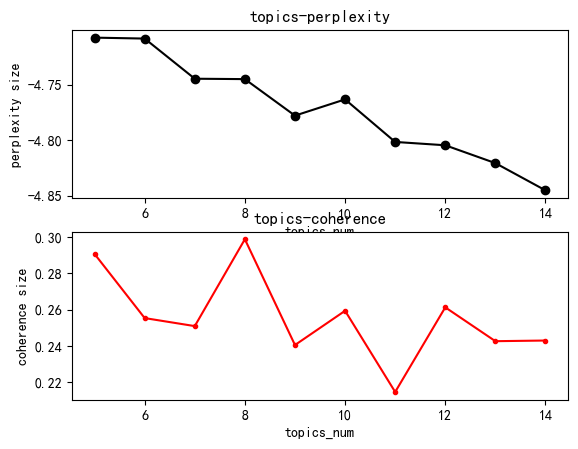

总耗时： 31.735689878463745


In [14]:
#计算困惑度
def compute_perplexity(topic_num):
    ldamodel = gensim.models.ldamodel.LdaModel.load('lda_model/'+ str(topic_num) + '/' + 'lda_model.model')
    return ldamodel.log_perplexity(corpus)

#计算一致性指标
def compute_coherence(topic_num):
    ldamodel = gensim.models.ldamodel.LdaModel.load('lda_model/'+ str(topic_num) + '/' + 'lda_model.model')
    dictionary = gensim.models.ldamodel.LdaModel.load('lda_model/'+ str(topic_num) + '/' + 'lda_model.model.id2word')
    ldacm = CoherenceModel(model=ldamodel, texts=text_cut, dictionary=dictionary, coherence='c_v')
    return ldacm.get_coherence()

starttime = time.time()
df = pd.read_csv('cssci_lda_cut.csv')  
df['text_cut'] = df['text_cut'].map(ast.literal_eval)
text_cut = df['text_cut'].tolist()  # 将列转化为数组形式
corpus = gensim.corpora.MmCorpus('lda_model/corpus.mm')

# 【与前文的topics_range一致】
x = range(5, 15)   
# 困惑度
y = [compute_perplexity(i) for i in tqdm(x)]
# 一致性
z = [compute_coherence(i) for i in tqdm(x)] 
print("perplexity and coherence are: ", y, z)

plt.subplot(2, 1, 1)
plt.plot(x, y, 'ko-')
plt.xlabel('topics_num')
plt.ylabel('perplexity size')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('topics-perplexity')

plt.subplot(2, 1, 2)
plt.plot(x, z, 'r.-')
plt.xlabel('topics_num')
plt.ylabel('coherence size')
plt.title('topics-coherence')
plt.show()
endtime = time.time()
print("总耗时：", (endtime - starttime))

困惑度随着主题数量的增加而下降，可能存在过拟合，因为更多的主题能够更细致地拟合数据，困惑度就会越低，而对于一致性而言，当主题数太多时，LDA模型会把训练数据分得过细，每个主题中的词会越来越专业或稀疏，这会导致主题中的高频词在原始文档中很少共现，从而降低了一致性分数。

图中显示，主题数量为8时，一致性的值是最高的，因此在这个样本中，我们将最优的主题数设为8。

### 最优主题数的主题词

In [10]:
# 加载保存的LDA模型
topic_num  = 8 #
lda_model  = gensim.models.ldamodel.LdaModel.load('lda_model/'+ str(topic_num) + '/' + 'lda_model.model')
dictionary = gensim.models.ldamodel.LdaModel.load('lda_model/'+ str(topic_num) + '/' + 'lda_model.model.id2word')
corpus     = corpora.MmCorpus('lda_model/corpus.mm')

# 输出模型
# 输出8个主题，每个主题4个词汇
print(lda_model.print_topics(num_topics=topic_num, num_words=4))  

[(0, '0.054*"分析" + 0.050*"进行" + 0.047*"方法" + 0.037*"基础"'), (1, '0.113*"影响" + 0.048*"显著" + 0.041*"不同" + 0.039*"程度"'), (2, '0.061*"影响" + 0.058*"提高" + 0.053*"银行" + 0.041*"政府"'), (3, '0.169*"中国" + 0.075*"产品" + 0.063*"产业" + 0.046*"条件"'), (4, '0.127*"企业" + 0.070*"我国" + 0.059*"一个" + 0.048*"问题"'), (5, '0.075*"影响" + 0.051*"经济增长" + 0.042*"我国" + 0.036*"数据"'), (6, '0.072*"市场" + 0.058*"发展" + 0.054*"中国" + 0.041*"我国"'), (7, '0.060*"形成" + 0.059*"不同" + 0.057*"具有" + 0.055*"行为"')]


### 每个文档的主题分布

In [16]:
document_topics = []

for doc in corpus:
    # 获取当前文档的主题分布
    doc_topics = lda_model.get_document_topics(doc)
    # 按概率排序
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    document_topics.append(doc_topics)

# 打印前5个文档的主题分布
for i, doc_topic in enumerate(document_topics[:5]):
    print(f"文档 {i+1} 的主题分布: {doc_topic}")

# 提取每个文档的主要主题
main_topics = []
for doc_topic in document_topics:
    # 获取概率最高的主题
    main_topic = max(doc_topic, key=lambda x: x[1])
    main_topics.append(main_topic)

# 打印前5个文档的主要主题
for i, (topic_id, prob) in enumerate(main_topics[:5]):
    print(f"文档 {i+1} 的主要主题: {topic_id}, 概率: {prob:.4f}, 主题词: {lda_model.print_topic(topic_id)}")

文档 1 的主题分布: [(4, 0.5084516), (0, 0.41851315), (2, 0.04172672)]
文档 2 的主题分布: [(5, 0.9618984)]
文档 3 的主题分布: [(6, 0.56949574), (0, 0.38880378)]
文档 4 的主题分布: [(1, 0.7061759), (3, 0.22554636), (0, 0.011385016), (5, 0.011383212), (4, 0.011382751), (7, 0.011379704), (6, 0.011374641), (2, 0.011372371)]
文档 5 的主题分布: [(3, 0.6863382), (6, 0.18033573), (1, 0.09160047)]
文档 1 的主要主题: 4, 概率: 0.5085, 主题词: 0.127*"企业" + 0.070*"我国" + 0.059*"一个" + 0.048*"问题" + 0.033*"重要" + 0.030*"国家" + 0.027*"之间" + 0.024*"进行" + 0.022*"主要" + 0.019*"模型"
文档 2 的主要主题: 5, 概率: 0.9619, 主题词: 0.075*"影响" + 0.051*"经济增长" + 0.042*"我国" + 0.036*"数据" + 0.033*"显著" + 0.032*"效应" + 0.030*"发现" + 0.027*"增长" + 0.023*"模型" + 0.021*"具有"
文档 3 的主要主题: 6, 概率: 0.5695, 主题词: 0.072*"市场" + 0.058*"发展" + 0.054*"中国" + 0.041*"我国" + 0.039*"重要" + 0.024*"方面" + 0.024*"具有" + 0.023*"经济" + 0.021*"社会" + 0.021*"方式"
文档 4 的主要主题: 1, 概率: 0.7062, 主题词: 0.113*"影响" + 0.048*"显著" + 0.041*"不同" + 0.039*"程度" + 0.035*"地区" + 0.034*"存在" + 0.034*"作用" + 0.033*"差异" + 0.031*"进行" + 0.029*"具有"
文档

### 绘制主题词云图

0.061*"影响" + 0.058*"提高" + 0.053*"银行" + 0.041*"政府" + 0.041*"水平" + 0.039*"商业银行" + 0.035*"下降" + 0.034*"增加" + 0.033*"降低" + 0.027*"存在" + 0.024*"显著" + 0.021*"企业" + 0.021*"相对" + 0.021*"分析" + 0.019*"发现" + 0.017*"考察" + 0.017*"提升" + 0.017*"程度" + 0.017*"中国" + 0.016*"关系" + 0.014*"进行" + 0.013*"导致" + 0.012*"变化" + 0.012*"市场" + 0.011*"表明" + 0.011*"主要" + 0.010*"利用" + 0.009*"不同" + 0.009*"经济" + 0.008*"面临" + 0.008*"一定" + 0.008*"实证分析" + 0.008*"具有" + 0.008*"之间" + 0.008*"数据" + 0.007*"出现" + 0.007*"问题" + 0.007*"情况" + 0.007*"结果显示" + 0.007*"有效" + 0.007*"模型" + 0.007*"结果表明" + 0.007*"差异" + 0.006*"生产" + 0.006*"能够" + 0.006*"国家" + 0.006*"指出" + 0.006*"这一" + 0.006*"产生" + 0.005*"形成" + 0.005*"实证研究" + 0.005*"一个" + 0.005*"特征" + 0.005*"解释" + 0.005*"进一步" + 0.004*"运用" + 0.004*"方面" + 0.004*"社会" + 0.004*"探讨" + 0.004*"结论" + 0.004*"采用" + 0.004*"风险" + 0.004*"相关" + 0.004*"这种" + 0.004*"促进" + 0.003*"作用" + 0.003*"建立" + 0.003*"传统" + 0.003*"选择" + 0.003*"调整" + 0.003*"发生" + 0.003*"此基础" + 0.003*"规模" + 0.003*"意义" + 0.003*"基本" + 0.003*"考虑" + 

C:\Users\gk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
C:\Users\gk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyecharts\render\snapshot.py:32: ResourceWarning: unclosed file <_io.BufferedWriter name='nul'>
  content = engine.make_snapshot(
C:\Users\gk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyecharts\render\snapshot.py:32: ResourceWarning: unclosed <socket.socket fd=5788, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 10449), raddr=('127.0.0.1', 10447)>
  content = engine.make_snapshot(


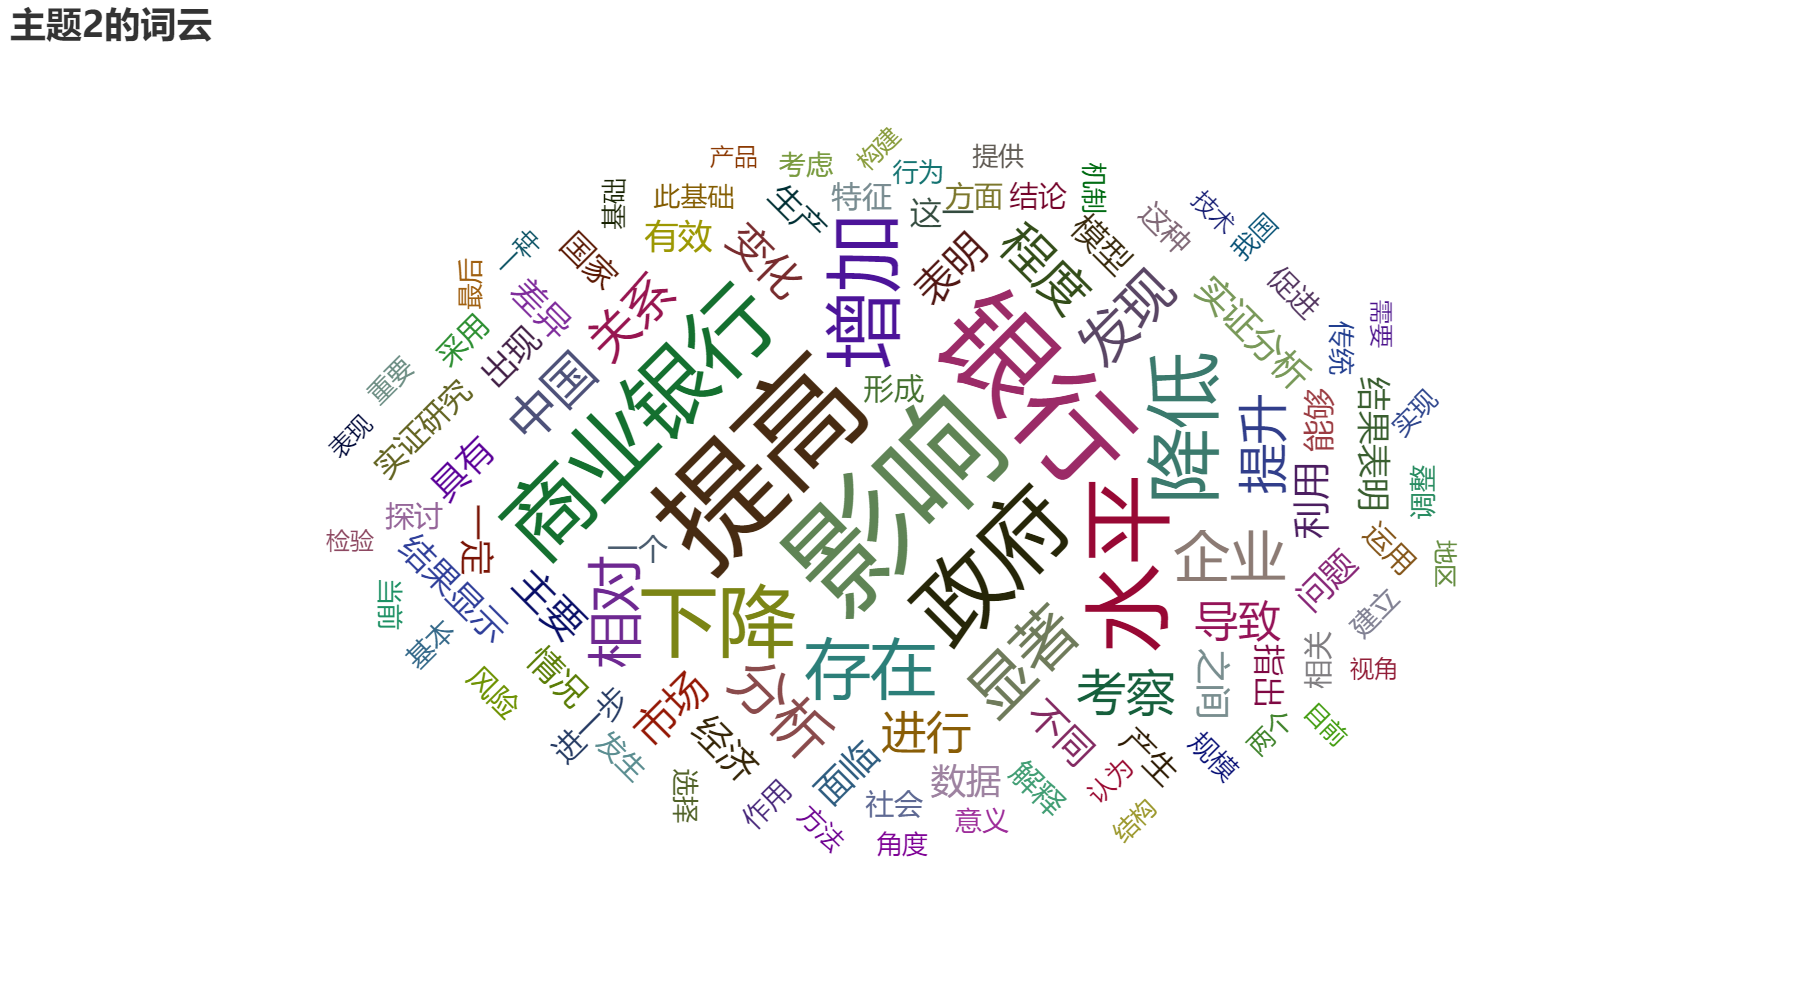

In [8]:
from pyecharts.charts import WordCloud
from pyecharts import options as opts
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from IPython.display import Image

topic_num = 8 #【设定主题数目】
topicn = 2 #【第几个主题】

lda        = gensim.models.ldamodel.LdaModel.load('lda_model/'+ str(topic_num) + '/' + 'lda_model.model')
topic_word = lda.print_topic(topicn,topn=100)
print(topic_word)
topic_word = topic_word.split(' + ')
word_score_list = []
for tw in topic_word:
    temp1 = tw.split('*')
    temp1[1] = eval(temp1[1])
    word_score_list.append(temp1)
print(word_score_list[:][0])
word=[x[1] for x in word_score_list]
count=[x[0] for x in word_score_list]
print(word[0:10])
print(count[0:10])

data=[]
for i in range(len(word_score_list)):
    temp=[(word[i],count[i])]
    data=data+temp
    
# 创建实例对象
c = WordCloud()
c.add(series_name="",data_pair=data)
# 设置标题
c.set_global_opts(title_opts=opts.TitleOpts("主题2的词云"))

# 保存为html
html_path = "lda_wordcloud.html"
c.render(html_path)

# 使用 selenium 将 HTML 转换为 PNG
make_snapshot(
    snapshot, 
    html_path,            # 传入 HTML 文件路径
    "lda_wordcloud.png",  # 输出 PNG 文件名
)

# 显示PNG图片
Image(filename='lda_wordcloud.png') 

# 2 Word2vec

## 2.1 为什么要使用Word2Vec

- 基于词频的词袋法将文档看做词语的无序组合，忽略了词语的上下文关系

## 2.2 Word2Vec的核心思想

- 语义相近的词出现在相似上下文中

## 2.3 Word2Vec原理
- 输入层：词的one-hot向量
- 隐藏层：将输入层的one-hot向量转化为一个低维的向量
- 输出层：目标词或者上下文词语的one-hot向量
- 优化目标：给定上下文词语后最大化正确预测中心词的条件概率，或者给定中心词后最大化正确预测上下文的概率
- 训练结果：矩阵W，其中的每一行就是每个词经过降维。训练后的词向量，并且词向量之前考虑了上下文的关系

![Word2Vec算法原理](Word2Vec算法原理.png)

## 2.4 Word2Vec训练方式

- CBOW：使用上下文词语预测中心词，适用于数据集较小的情况
- Skip-gram：使用中心词预测上下文词语，适用于数据集较大的情况

  ![CBOW和Skip-gram示意图](Word2Vec训练方式.png)

## 2.4 Word2Vec计算文本相似性

In [26]:
from gensim.models import Word2Vec
os.chdir("D:/aSchool/aWHU\学习班/07深度学习/word2vec/")

cssci = pd.read_csv('cssci_clean_short.csv')
sentences_list = cssci['abstract'].tolist()
# 提取前500个样本进行演示
sentences_list = sentences_list[:500]
print(cssci.shape[0])
print(cssci)

18720
       Unnamed: 0                                           abstract  \
0               0  本文借用均值定理的思路和方法测度中国各地在新发展理念语境下社会经济民生福祉和谐发展与否的"二...   
1               1  本文从环境影响评估、损害赔偿和海洋保护区3个方面梳理了国际公约和一些国家制定的与海洋生态补偿...   
2               2  目前全国流动人口数量已经超过2.47亿,并呈现上升趋势,研究这一群体的消费行为对于实现中国经...   
3               3  最低工资的提高是否会影响价格水平?本文通过构建企业—产品层级的理论模型,指出最低工资标准的变...   
4               4  本文采用文本分析方法构建了融资约束指标,在此基础上,实证检验了多个大股东对企业融资约束的影响...   
...           ...                                                ...   
18715       19995  价格上限管制是目前被普遍采用的自然垄断行业的价格管制方式。但是,基于企业并不总是拥有精确的成...   
18716       19996  本文运用DEA-Malmquist生产率指数分析方法,对转型期中国农业全要素生产率增长的时间...   
18717       19997  本文运用组织学习论和制度因素论,对中国企业实施海外并购对自身经营绩效的影响进行了理论探论,并...   
18718       19998  采用我国14家上市银行1992-2007年的面板数据,从盈利水平和资产质量两个方面对境外战略...   
18719       19999  本文运用理论建模和多元门限协整的实证相结合的方法,对人民币汇率升值通过影响出口,从而影响失业...   

                 author                                        author_unit  \
0              刘珊珊; 马志远                            

In [27]:
# 分词
#加载停用词表
stopwords = [ line.strip() for line in open('stopword.txt','r').readlines()]
#把关键词做成字典
jieba.load_userdict("keyword.txt") 
sentences_cut = []
#结巴分词
for ele in sentences_list:
    cuts = jieba.cut(ele,cut_all=False)
    new_cuts = []
    for cut in cuts:
        # 剔除停用词和字符数小于1的词  
        if (cut not in  stopwords) & (len(cut)>1):         
            new_cuts.append(cut)
    sentences_cut.append(new_cuts)
print(sentences_cut[0: 10])

C:\Users\gk\AppData\Local\Temp\ipykernel_23084\1037012188.py:3: ResourceWarning: unclosed file <_io.TextIOWrapper name='stopword.txt' mode='r' encoding='cp936'>
  stopwords = [ line.strip() for line in open('stopword.txt','r').readlines()]
C:\Users\gk\AppData\Local\Temp\ipykernel_23084\1037012188.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='keyword.txt'>
  jieba.load_userdict("keyword.txt")


[['借用', '均值', '定理', '思路', '各地', '新发展', '理念', '语境', '社会', '经济', '民生', '福祉', '和谐发展', '二元', '离散', '特征', 'Probit', '二元', '离散', '模型检验', '中国式分权', '体制', '地方政府', '财政支出', '治理能力', '社会', '经济', '民生', '福祉', '和谐发展', '实证研究', '287', '地级市', '和谐发展', '偏离', '指数', '时间推移', '收敛', '态势', '标尺竞争', '引致', '俱乐部', '效应', '明显', '区域', '区域', '并存', '现象', '十分', '普遍', '经济发展水平', '并非', '地区', '和谐发展', '原因', '政府', '财政', '支出结构偏向', '关系密切', '五大', '发展', '全新', '理念', '语境', '地方政府', '财政支出结构', '调适', '社会', '经济', '民生', '福祉', '和谐发展', '改进', '空间', '有望'], ['环境影响', '评估', '损害赔偿', '海洋', '保护区', '国际公约', '一些', '国家', '制定', '海洋生态补偿', '制度', '治理', '目标', '治理', '方式', '治理', '手段', '层面', '概括', '海洋生态补偿', '国际', '治理实践', '借鉴', '国际经验', '海洋生态补偿', '法律法规', '管理制度', '整合', '管理机制', '政策建议'], ['目前', '全国', '流动人口', '数量', '已经', '超过', '2.47', '呈现', '上升', '趋势', '这一', '群体', '消费行为', '中国经济', '内生性', '增长', '意义', '国家', '计委', '2015', '流动人口', '动态监测', '统计', '显示', '60%', '以上', '流动人口', '长期', '定居', '意愿', '工具变量', '回归', '流动人口', '居留意愿', '家庭', '消费水平', '相比', '群体', '打算', '本地', '长期', '居住', '以上'

### Word2Vec参数含义

1. sentences_cut：分词的结果，在这里是一个列表

2. vector_size：词向量的维度，默认值是100，其取值一般与语料的大小相关，视语料库的大小而定

3. min_count：对字典进行过滤，词频少于多少次的词语会被去掉

4. window：即词向量上下文最大距离，默认为5

5. sg: 0表示使用CBOW模型，1表示使用Skip-Gram模型

In [30]:
import multiprocessing
#训练模型
model = Word2Vec(sentences_cut,vector_size=10, min_count=1, window=5,sg=0, workers=multiprocessing.cpu_count())
print(model)
vectors = model.wv.vectors    
print("获取模型的全部向量", vectors)
#获取模型中全部的词
words = model.wv.index_to_key   
print(words[0: 20])

Word2Vec<vocab=8030, vector_size=10, alpha=0.025>
获取模型的全部向量 [[ 1.8139322e-01 -8.4724464e-02  2.9245940e-01 ...  3.3172750e-01
  -5.5132806e-01 -2.2762246e-01]
 [ 2.1715736e-01 -7.8659751e-02  1.0227873e-01 ...  1.6279587e-01
  -4.1437763e-01 -2.1916009e-01]
 [ 1.9058765e-01  2.4681614e-04  2.2426258e-01 ...  2.1678451e-01
  -3.8847610e-01 -1.5839140e-01]
 ...
 [-2.2510584e-02 -9.5014758e-02 -9.1809906e-02 ...  2.3126638e-02
  -5.4016627e-02 -8.8572286e-02]
 [ 1.5925722e-02 -6.4395651e-02 -8.4885634e-02 ... -7.9516340e-03
  -9.7456701e-02 -6.8905026e-02]
 [ 6.8113334e-02 -1.5201910e-02 -6.8389587e-02 ... -3.2038160e-02
   7.2948597e-02  5.1718127e-02]]
['企业', '公司', '政府', '提供', '发展', '经济', '政策', '结论', '行业', '机制', '农户', '创新', '特征', '国家', '地区', '效应', '创业', '家庭', '探讨', '明显']


In [32]:
# 获取单个词的向量，以“研发”为例
vec = model.wv['研发']
print(vec)
#计算2个词之间的余弦相似度
print(model.wv.similarity("研发", "创新"))
# 找出前N个最相似的词
model.wv.most_similar(positive=["研发"],topn=10)  # positive表示与研发同方向的词

[ 0.07371853 -0.00648697  0.04831385  0.06160745 -0.03222536  0.08572765
 -0.04201933 -0.00881482 -0.11740053 -0.00442084]
0.4412819


[('大学', 0.941646158695221),
 ('排位', 0.9149936437606812),
 ('对策建议', 0.8895519375801086),
 ('四大地区', 0.8813504576683044),
 ('关联', 0.8686463236808777),
 ('投入产出效率', 0.8659204840660095),
 ('社会关系', 0.864177942276001),
 ('微观经济', 0.8569911122322083),
 ('战略风险', 0.8418760299682617),
 ('加工贸易', 0.8345787525177002)]

# 3 GPT模型

## 3.1. GPT模型的基本概念

GPT模型是一种基于transformer架构的语言模型，目标是通过大规模的无监督预训练来学习语言的概率分布。

GPT的预训练流程：

第一步：分词。

第二步：每个词语映射为一个固定的词嵌入向量，并与位置编码相加，作为模型输入。

第三步：使用Transformer的解码器对词向量进行调整。Transformer 解码器处理所有输入词语的词向量，生成每个位置的上下文敏感的动态词表示，同一个词在不同上下文中对应不同的向量。

第四步：使用每个位置的上下文向量预测下一个词语的概率分布，逐步生成连贯的文本。

第五步：参数优化。在自回归语言模型中，通过最大化生成真实训练样本的概率，更新词嵌入矩阵、Transformer 参数及输出层参数。

## 3.2 使用GPT进行情感分析

In [33]:
import requests
import parsel
import openai 
from openai import RateLimitError 
import os
from time import sleep

请求新浪财经的首页url，拿到对应的响应数据

In [34]:
# 请求的目标地址
url = "https://finance.sina.com.cn/" 
# 使用requests库来发送GET请求，获得响应
res = requests.get(url) 

修改响应数据的编码，解决中文乱码的问题，然后使用`parsel`库解析响应数据提取要闻相关的数据

In [35]:
# 将编码设置为utf-8
res.encoding = "utf-8" 
# 将响应数据进行解析
page = parsel.Selector(res.text) 
# 找 class值为fin_tabs0_c0的div节点
outer_div = page.xpath("//div[@class='fin_tabs0_c0']") 
# div下所有的a节点
a_under_div = outer_div.xpath(".//a") 
# 声明一个列表来存储数据
data = list() 
# 遍历每一个a节点，取其href和文本值
for item in a_under_div: 
    # 文本值作为要闻标题
    news_title = item.xpath("./text()").extract_first() 
    # href值作为要闻url
    news_url = item.xpath("./@href").extract_first() 
    this_data = {
        "news_title" : news_title,
        "news_url" : news_url, 
    }
    data.append(this_data)
pprint(data)

[{'news_title': '以色列袭击伊朗',
  'news_url': 'https://finance.sina.com.cn/stock/marketresearch/2025-06-13/doc-inezwrzq6213099.shtml'},
 {'news_title': '金价、油价，狂飙！',
  'news_url': 'https://finance.sina.com.cn/stock/marketresearch/2025-06-13/doc-inezxark6067186.shtml'},
 {'news_title': '多位伊朗核科学家遭以色列袭击身亡',
  'news_url': 'https://finance.sina.com.cn/roll/2025-06-13/doc-inezwwin6138952.shtml'},
 {'news_title': '美国声明称未参与打击伊朗',
  'news_url': 'https://finance.sina.com.cn/world/2025-06-13/doc-inezwrzm7451627.shtml'},
 {'news_title': '伊朗:以色列的侵略美国政府应承担责任',
  'news_url': 'https://finance.sina.com.cn/roll/2025-06-13/doc-inezxarf7272340.shtml'},
 {'news_title': '以色列城市特拉维夫遭袭',
  'news_url': 'https://finance.sina.com.cn/jjxw/2025-06-13/doc-inezxark6060989.shtml'},
 {'news_title': '市场高度关注"伊朗反击的速度和规模"',
  'news_url': 'https://finance.sina.com.cn/roll/2025-06-13/doc-inezwwiq6677065.shtml'},
 {'news_title': '袭击伊朗之前发生了什么?',
  'news_url': 'https://finance.sina.com.cn/world/2025-06-13/doc-inezxarf7259688.shtml'},

### 调用Chatgpt的API

到https://platform.closeai-asia.com 上注册账号，充值后，打开开发者模型-秘钥管理-代码示例，将里面的代码复制下来即可

In [40]:
from openai import OpenAI
# 调用API
if __name__ == '__main__':
    client = OpenAI(
        # openai系列的sdk，包括langchain，都需要这个/v1的后缀
        base_url='https://api.openai-proxy.org/v1',
        api_key='sk-XGxWr04rhZAXL8LIZRRifSGZ2s3xqa1Aq2Va5l9lDxqgu1vc',
    )

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": "Say hi",
            }
        ],
        model="gpt-4o-mini", # 如果是其他兼容模型，比如deepseek，直接这里改模型名即可，其他都不用动
    )

    print(chat_completion)

ChatCompletion(id='chatcmpl-BhrbJhm3Eqs0G33mAxutfUFwFL9vt', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hi there! How can I assist you today?', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1749793845, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_57db37749c', usage=CompletionUsage(completion_tokens=11, prompt_tokens=9, total_tokens=20, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


`temperature`的值为0代表期望模型的输出更加集中和确定

In [41]:
def judge_sentiment(news_title):
    res = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": '忘掉之前所有的指令。假装你是一位金融专家。你是一位有荐股经验的金融专家。如果是好消息，请回答 "积极"；如果是坏消息，请回答 "消极"；如果是不确定的消息，请回答 "未知"。然后用一个简短的句子详细说明。'},
            {"role": "user", "content": news_title},
        ],
        temperature=0,
    )
    return res.choices[0].message.content

将上面爬取到的要闻标题传入到`judge_sentiment`函数中，并且将返回的结果打印

In [42]:
# 遍历新闻标题并分析情感
for item in data[:10]:
    news_title = item['news_title']
    print("新闻标题：%s" % news_title)
    print("情感分析结果：%s" % judge_sentiment(news_title))
    print("-" * 30)

新闻标题：以色列袭击伊朗
情感分析结果：消极。此事件可能导致中东地区的紧张局势加剧，从而影响全球市场和投资者信心。
------------------------------
新闻标题：金价、油价，狂飙！
情感分析结果：消极。金价和油价的狂飙通常意味着市场不稳定，可能引发通货膨胀和经济不确定性。
------------------------------
新闻标题：多位伊朗核科学家遭以色列袭击身亡
情感分析结果：消极。此事件可能加剧中东地区的紧张局势，对相关市场产生负面影响。
------------------------------
新闻标题：美国声明称未参与打击伊朗
情感分析结果：积极。美国的声明可能有助于缓解中东地区的紧张局势，从而对市场产生正面影响。
------------------------------
新闻标题：伊朗:以色列的侵略美国政府应承担责任
情感分析结果：消极。此消息可能加剧中东地区的紧张局势，影响相关市场的稳定性。
------------------------------
新闻标题：以色列城市特拉维夫遭袭
情感分析结果：消极。特拉维夫遭袭可能导致市场不稳定，影响投资者信心。
------------------------------
新闻标题：市场高度关注"伊朗反击的速度和规模"
情感分析结果：未知。市场对伊朗反击的速度和规模的反应尚不明确，可能会影响地缘政治风险和相关资产的波动。
------------------------------
新闻标题：袭击伊朗之前发生了什么?
情感分析结果：未知。袭击前的具体事件和背景信息可能会影响市场反应，但目前尚不清楚这些事件的具体影响。
------------------------------
新闻标题：商务部回应中美经贸磋商话题
情感分析结果：未知。商务部的回应可能会影响未来的经贸关系，但具体影响尚不明确。
------------------------------
新闻标题：商务部：中国已依法批准一定数量稀土相关物项出口许可合规申请
情感分析结果：积极。此举表明中国在稀土出口方面采取了合规措施，有助于稳定市场供应并可能提升相关企业的业绩。
------------------------------


# 4 使用爬虫批量下载年报

### 4.1 定义年报爬取函数

In [1]:
import requests
import re
import pdfplumber

def get_response(page_num,date):
    url = "http://www.cninfo.com.cn/new/hisAnnouncement/query"
    headers = {
        "Accept": "*/*",
        "Accept-Encoding": "gzip, deflate",
        "Accept-Language": "zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6",
        "Content-Length": "195",
        "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
        "Host": "www.cninfo.com.cn",
        "Origin": "http://www.cninfo.com.cn",
        "Proxy-Connection": "keep-alive",
        "Referer": "http://www.cninfo.com.cn/new/commonUrl/pageOfSearch?url=disclosure/list/search&checkedCategory=category_ndbg_szsh",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36 Edg/113.0.1774.42",
        "X-Requested-With": "XMLHttpRequest"
    }
    '''
    参数列表
     plate: sz;sh, 表示沪深两市
     seDate：查询时间
    '''
    data = {
        "pageNum": page_num,
        "pageSize": 30,
        "column": "all",
        "tabName": "fulltext",
        "plate": "sz;sh",
        "searchkey": "",
        "secid": "",
        "category": "category_ndbg_szsh",
        "trade": "",
        "seDate": date,
        "sortName": "code",
        "sortType": "asc",
        "isHLtitle": "false"
    }
    response = requests.post(url, data=data, headers=headers)
    return response

def get_ann_info(date):
    all_results = []
    page_num = 1
    response_test = get_response(page_num, date)

    data_test = response_test.json()
    total_pages = data_test["totalpages"]

    # 检查total_pages是否为0
    if total_pages == 0:
        return all_results  # 提前返回空结果

    max_retries = 3  # 最大重试次数

    while page_num <= total_pages+1:  # 多处理一页
        retry_count = 0  # 当前重试次数
        while retry_count <= max_retries:
            try:
                # 请求报告数据
                response = get_response(page_num, date)
                response.raise_for_status()
                data = response.json()

                # 解析并处理数据
                if data["announcements"] is None:
                    raise Exception("公告数据为空")
                else:
                    all_results.extend(data["announcements"])
                # 跳出重试循环
                break

            except requests.exceptions.RequestException as e:
                print(f"出现网络请求错误！: {e}")
                print(f"5秒后重试...")
                time.sleep(5)
                retry_count += 1

            except (ValueError, KeyError) as e:
                print(f"解析响应数据失败: {e}")
                print(f"5秒后重试...")
                time.sleep(5)
                retry_count += 1

            # 如果达到最大重试次数，跳过此页
            if retry_count > max_retries:
                print(f"{max_retries}次重试后均失败. 跳过第{page_num}页.")
                break

        page_num += 1
    return all_results

#下载pdf和txt
def download_pdf_txt(pdf_url, pdf_file_path):
    # 下载pdf
    with requests.get(pdf_url, stream=True, timeout=10) as r:
        r.raise_for_status()
        with open(pdf_file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    # 将pdf转化为txt
    txt_file_path = pdf_file_path[:-3]+'txt'
    with pdfplumber.open(pdf_file_path) as pdf:
        with open(txt_file_path, 'w', encoding='utf-8') as f:
            for page in pdf.pages:
                text = page.extract_text()
                f.write(text)

### 爬取部分股票的2022年年报

In [8]:
# 导入A股股票代码列表
Stkcd_Code = pd.read_csv('D:/aSchool/aWHU/学习班/文本分析/Stk.csv')

# 将股票代码转化为字符串
Stkcd_Code['Stkcd'] = Stkcd_Code['Stkcd'].apply(lambda x: f"{int(x):06d}")
# 股票代码转化为列表
Stkcd_Code  = Stkcd_Code['Stkcd'].tolist()
# 为节约时间，只取100支股票
Stkcd_Code  = Stkcd_Code[:100]

Year = 2022

# 获取所有沪深所有股票的年报信息
Ann_Info = get_ann_info(f'{Year+1}-01-01~{Year+1}-04-30')

# 获取特定股票的年报链接
Url_Dict = {}
for info in Ann_Info:
    if '摘要' not in info['announcementTitle'] and info['secCode'] in Stkcd_Code:
        Url_Dict[info['secCode']]='http://static.cninfo.com.cn/'+info['adjunctUrl']
print(len(Url_Dict))
print('股票000001的2022年年报链接为{}'.format(Url_Dict['000001']))

86
股票000001的2022年年报链接为http://static.cninfo.com.cn/finalpage/2023-03-09/1216072952.PDF


## 4.2 循环下载每一支股票的年报

In [5]:
count = 0
for key, value in Url_Dict.items():
    pdf_file_path = 'D:/aSchool/aWHU/学习班/文本分析/annual_reports/'+key+'_'+str(Year)+'.pdf'
    download_pdf_txt(value,pdf_file_path)
    count+=1
    print('{}的{}年报下载完成，进度{:.2%}'.format(key,Year,count/len(Url_Dict)))

000001的2022年报下载完成，进度1.16%
000002的2022年报下载完成，进度2.33%
000004的2022年报下载完成，进度3.49%
000005的2022年报下载完成，进度4.65%
000006的2022年报下载完成，进度5.81%
000007的2022年报下载完成，进度6.98%
000008的2022年报下载完成，进度8.14%
000009的2022年报下载完成，进度9.30%
000010的2022年报下载完成，进度10.47%
000011的2022年报下载完成，进度11.63%
000012的2022年报下载完成，进度12.79%
000014的2022年报下载完成，进度13.95%
000016的2022年报下载完成，进度15.12%
000017的2022年报下载完成，进度16.28%
000019的2022年报下载完成，进度17.44%
000020的2022年报下载完成，进度18.60%
000021的2022年报下载完成，进度19.77%
000023的2022年报下载完成，进度20.93%
000025的2022年报下载完成，进度22.09%
000026的2022年报下载完成，进度23.26%
000027的2022年报下载完成，进度24.42%
000028的2022年报下载完成，进度25.58%
000029的2022年报下载完成，进度26.74%
000030的2022年报下载完成，进度27.91%
000031的2022年报下载完成，进度29.07%
000032的2022年报下载完成，进度30.23%
000034的2022年报下载完成，进度31.40%
000035的2022年报下载完成，进度32.56%
000036的2022年报下载完成，进度33.72%
000037的2022年报下载完成，进度34.88%
000039的2022年报下载完成，进度36.05%
000040的2022年报下载完成，进度37.21%
000042的2022年报下载完成，进度38.37%
000045的2022年报下载完成，进度39.53%
000046的2022年报下载完成，进度40.70%
000048的2022年报下载完成，进度41.86%
000049的2022年报下载完成，进度43.02%
000050的20

Cannot set gray non-stroke color because /'Pattern1' is an invalid float value
Cannot set gray non-stroke color because /'Pattern2' is an invalid float value
Cannot set gray non-stroke color because /'Pattern3' is an invalid float value
Cannot set gray non-stroke color because /'Pattern4' is an invalid float value
Cannot set gray non-stroke color because /'Pattern5' is an invalid float value
Cannot set gray non-stroke color because /'Pattern6' is an invalid float value
Cannot set gray non-stroke color because /'Pattern7' is an invalid float value
Cannot set gray non-stroke color because /'Pattern8' is an invalid float value
Cannot set gray non-stroke color because /'Pattern1' is an invalid float value
Cannot set gray non-stroke color because /'Pattern2' is an invalid float value
Cannot set gray non-stroke color because /'Pattern3' is an invalid float value
Cannot set gray non-stroke color because /'Pattern4' is an invalid float value
Cannot set gray non-stroke color because /'Pattern5'

000089的2022年报下载完成，进度62.79%
000090的2022年报下载完成，进度63.95%
000096的2022年报下载完成，进度65.12%
000099的2022年报下载完成，进度66.28%
000100的2022年报下载完成，进度67.44%
000150的2022年报下载完成，进度68.60%
000151的2022年报下载完成，进度69.77%
000153的2022年报下载完成，进度70.93%
000155的2022年报下载完成，进度72.09%
000156的2022年报下载完成，进度73.26%
000157的2022年报下载完成，进度74.42%
000158的2022年报下载完成，进度75.58%
000159的2022年报下载完成，进度76.74%
000166的2022年报下载完成，进度77.91%
000301的2022年报下载完成，进度79.07%
000333的2022年报下载完成，进度80.23%
000338的2022年报下载完成，进度81.40%
000400的2022年报下载完成，进度82.56%
000401的2022年报下载完成，进度83.72%
000402的2022年报下载完成，进度84.88%
000403的2022年报下载完成，进度86.05%
000404的2022年报下载完成，进度87.21%
000407的2022年报下载完成，进度88.37%
000408的2022年报下载完成，进度89.53%
000409的2022年报下载完成，进度90.70%
000410的2022年报下载完成，进度91.86%
000411的2022年报下载完成，进度93.02%
000413的2022年报下载完成，进度94.19%
000415的2022年报下载完成，进度95.35%
000416的2022年报下载完成，进度96.51%
000417的2022年报下载完成，进度97.67%
000419的2022年报下载完成，进度98.84%
000420的2022年报下载完成，进度100.00%


# 5 使用文本分析提取年报信息（MD&A）

## 5.1 数据预处理

In [10]:
import re
import os
import pdb
import tqdm
from pathlib import Path
import re
import pickle
from itertools import chain
from functools import reduce
from multiprocessing import pool, cpu_count
import jieba

# 定义MDA的标题，开始和结束关键词
head_of_MDA = ["管理层讨论与分析", "经营情况讨论与分析", "董事会报告", "董事局报告"]
pattern_of_MDA = [
    "第.节\s*?管理层讨论与分析(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?股份变动及股东情况(?!\”)(?!\s*?\.)\s+?)",
    "第.节\s*?管理层讨论与分析(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?重要事项(?!\”)(?!\s*?\.)\s+?)",
    "第.节\s*?经营情况讨论与分析(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?重要事项(?!\”)(?!\s*?\.)\s+?)",
    "第.节\s*?董事会报告(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?重要事项(?!\”)(?!\s*?\.)\s+?)",
    "第.节\s*?董事局报告(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?重要事项(?!\”)(?!\s*?\.)\s+?)",
    "第.节\s*?董事会报告(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?监事会报告(?!\”)(?!\s*?\.)\s+?)",
    "第.节\s*?董事局报告(?!\s*?\.)(?!\w)(?!”)[\s\S]+?(?=第.*?监事会报告(?!\”)(?!\s*?\.)\s+?)",
]

# 清除年报的目录
def remove_catalogue(path, dealed_path, file_list):  # 清除年报的目录，以方便截取关键部分
    for filename in tqdm.tqdm(file_list, desc="清除年报目录"):
        try:
            with open(filename, "r", encoding="utf-8") as f1, open(dealed_path.joinpath(filename.name), "w", encoding="utf-8") as f2:
                text = f1.read()
                for i in range(len(head_of_MDA)):
                    target = head_of_MDA[i] + "[\s\S]+?" + head_of_MDA[i]
                    content = re.search(target, text)
                    if content != None:
                        content = content.group()[: -len(head_of_MDA[i])]
                        text = text.replace(content, "")
                        break
                f2.write(text + "\n")
                f2.flush()
        except:
            pass

# 提取MD&A内容
def extract(dealed_path, caught_path, file_list):  # 根据规则抓取数据
    for filename in tqdm.tqdm(file_list, desc="提取MD&A"):
        pattern_of_MDA_file = filename.name
        try:
            with open(dealed_path.joinpath(filename.name), "r", encoding="utf-8") as f1, open(caught_path.joinpath(pattern_of_MDA_file), "w", encoding="utf-8") as f2:
                text = f1.read()
                for i in range(len(pattern_of_MDA)):
                    target = pattern_of_MDA[i]
                    data = re.search(target, text)
                    if data != None:
                        f2.write(data.group())
                        f2.flush()
                        break
        except:
            pass

# 获取提取失败的年报列表，判断方法为读取匹配文件的内容，如该文件内容过小，则判断其为匹配失败
def get_todo_list(caught_path):
    caught_file = caught_path.glob("*.txt")
    error_list = []
    for file in caught_file:
        if file.stat().st_size < 5 * 1024:  # 如果文件大小不足5KB，就判断为匹配失败
            error_list.append(file)
    return error_list

# 再次对截取失败的年报进行处理，大部分失败的原因是没有成功的清除掉目录部分
def removecatalogue_and_catch(dealed_path, caught_path, try_num):
    print("try 3 more times")
    todo_list = get_todo_list(caught_path)
    while len(todo_list) > 0 and try_num > 0:
        for file in tqdm.tqdm(todo_list, desc="再次处理"):
            pattern_of_MDA_path = dealed_path.joinpath("_".join(file.name.split("_")[-2:]))
            with pattern_of_MDA_path.open(mode="r+", encoding="utf-8") as f:
                text = f.read()  # 读取文件的内容，再次清除目录
                f.truncate()  # 清除掉文件的内容
                for i in range(len(head_of_MDA)):
                    target = head_of_MDA[i] + "[\s\S]+?" + head_of_MDA[i]
                    content = re.search(target, text)
                    if content != None:
                        content = content.group()[: -len(head_of_MDA[i])]
                        text = text.replace(content, "")
                        break
                f.write(text + "\n")
        extract(dealed_path, caught_path, todo_list)
        todo_list = get_todo_list(caught_path)
        try_num -= 1

### 提取86个年报的MD&A部分，放入到md&a目录下， 供后续数据分析使用

In [11]:
path = Path("D:/aSchool/aWHU/学习班/文本分析/annual_reports")  # 原始年报存放路径
dealed_path = Path("D:/aSchool/aWHU/学习班/文本分析/catalogue_removed")  # 删除了目录部分的年报要存储的目录
caught_path = Path("D:/aSchool/aWHU/学习班/文本分析/md&a")  # 年报截取的部分要存储的目录

dealed_path.mkdir(exist_ok=True)  # 创建需要的文件夹
caught_path.mkdir(exist_ok=True)  # 创建需要的文件夹

file_list = list(path.glob("*.txt"))  # 获得所有要提取的年报的名字

remove_catalogue(path, dealed_path, file_list)
extract(dealed_path, caught_path, file_list)
removecatalogue_and_catch(dealed_path, caught_path, 3)
for i in get_todo_list(caught_path):
    i.unlink()  # 删除掉提取失败的文本

提取MD&A: 100%|███████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 229.15it/s]


try 3 more times


提取MD&A: 100%|██████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 17.54it/s]


### 分词

定义分词函数

In [12]:
sentences_sep = re.compile("。|！|\!|\.|？|\?")  # 根据正则表达式来切分句子

def process_cut(file):
    content = file.read_text(encoding="utf-8") # 指定读入的文字编码为utf-8
    # 使用jieba进行分词，并将停用词以及特殊符号过滤掉
    sentences_res = [[word for word in jieba.lcut(sent)] for sent in re.split(sentences_sep, content)]
    doc_word_res = list(chain(*sentences_res))  # 将中间的列表压平
    return sentences_res, doc_word_res


def hasNumbers(inputString):  # 使用正则表达式来判断是否为数字
    return bool(re.search(r"\d", inputString))


def isSymbol(inputString):  # 使用正则表达式来判断是否为特殊符号
    return bool(re.match(r"[^\w]", inputString))


def isAlphaBeta(inputString): # 使用正则表达式来判断是否为英文字母
    return bool(re.match(r"^[a-zA-Z]+?$", inputString))


def clean_func(inputStr):  # 用来清洗掉数字以及特殊符号和停用词
    return inputStr not in STOPWORDS_zh and not hasNumbers(inputStr) and not isSymbol(inputStr) and inputStr != "\n" and not isAlphaBeta(inputStr)

def filter_word(sent_res, doc_word_res):
    # sr内为句子经过清洗后的表达
    # dd为文档内经过清洗后的表达
    sr = [[word for word in sent if clean_func(word)] for sent in sent_res]
    dd = [word for word in doc_word_res if clean_func(word)]
    return sr, dd

In [13]:
all_mda_file = Path("D:/aSchool/aWHU/学习班/文本分析/md&a")  # 声明放置匹配MD&A内容的文件夹
all_files = list(all_mda_file.glob("*.txt"))  # 获得所有MD&A文件的文件名
all_word = []  # 用来存储所有的分词后的单词
doc_word = []  # 用来存储每个文档对应的单词列表，每个文档为一个列表，每个列表对应一篇文档的分词结果
doc_sentences = []  # 用来存储每个文档对应的句子列表，每个文档为多个列表，每个列表对应一个句子的分词结果

res = []
for file in all_files:
    result = process_cut(file)
    res.append(result)
print(len(res))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\gk\AppData\Local\Temp\jieba.cache
Loading model cost 0.608 seconds.
Prefix dict has been built successfully.


80


去停用词

In [14]:
os.chdir('D:/aSchool/aWHU/学习班/文本分析/')

# filter_pool = pool.Pool(processes=4)  # 使用多进程加速处理,
# filter_res = filter_pool.starmap_async(filter_word, tqdm.tqdm(res, desc="去停用词"))
# filter_pool.close()
# filter_pool.join()
# for sent_res, doc_word_res in tqdm.tqdm(filter_res.get(), desc="填充列表"):
#     doc_sentences.append(sent_res)
#     all_word.extend(doc_word_res)
#     doc_word.append(doc_word_res)

for result in res:
    filter_res = filter_word(result[0],result[1])
    doc_sentences.append(filter_res[0])
    all_word.extend(filter_res[1])
    doc_word.append(filter_res[1])
    
# 将预处理之后的结果缓存起来，供后续数据分析使用
with open("all_word.pth", "wb") as f1, open("doc_word.pth", "wb") as f2, open("doc_sentences.pth", "wb") as f3:
    pickle.dump(all_word, f1)
    pickle.dump(doc_word, f2)
    pickle.dump(doc_sentences, f3)
print('文本预处理结果：')
print(doc_sentences[0][0])

文本预处理结果：
['第四节', '董事会', '报告', '经营', '情况', '讨论', '分析', '房地产', '行业', '经历', '深度', '调整', '全国', '商品房', '销售', '金额', '同比', '大幅', '下滑', '各地', '房价', '持续', '承压', '房企', '资产', '负债表', '遭受', '冲击', '部分', '企业', '出现', '流动性', '风险']


## 5.2 文档表示

In [1]:
from pathlib import Path
from wordcloud import WordCloud
from collections import Counter
import os
import matplotlib.pylab as plt
from matplotlib import colors
from PIL import Image
import numpy as np
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
from tqdm import tqdm
from zhconv import convert
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import jieba
from io import StringIO

导入分词结果

In [2]:
os.chdir('D:/aSchool/aWHU/学习班/文本分析/')
with open("all_word.pth", "rb") as f1, open("doc_word.pth", "rb") as f2, open("doc_sentences.pth", "rb") as f3:
    all_word = pickle.load(f1)
    doc_word = pickle.load(f2)
    doc_sentences = pickle.load(f3)

生成词云图

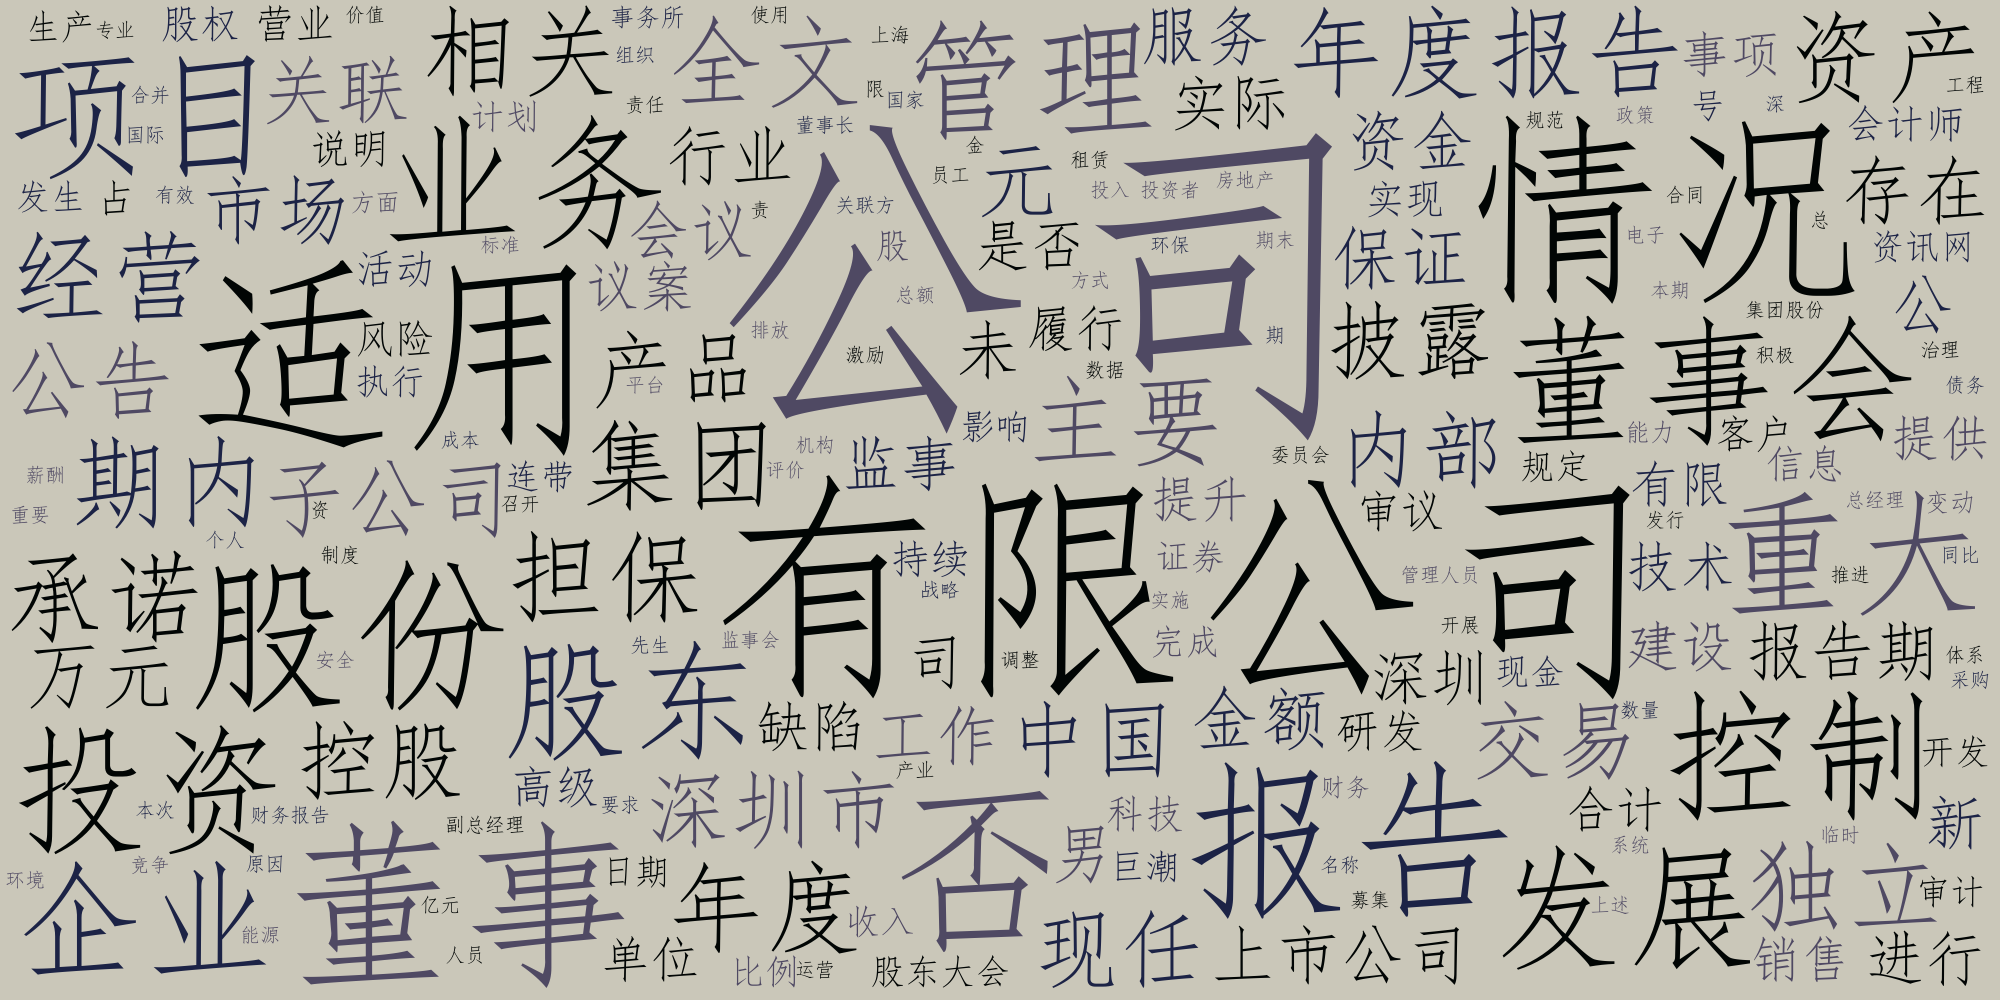

In [35]:
color_list = ["#010504", "#4f4963", "#1c2346"]  # 自定义颜色列表
colormap = colors.ListedColormap(color_list)
wc = WordCloud(colormap=colormap, background_color="#cac7b9", scale=5, prefer_horizontal=1.0, font_path=r"simfang.ttf")  # 声明词云对象
word_count = Counter(all_word)  # 根据分词的结果统计词频
wc.generate_from_frequencies(word_count)  # 按照词频生成词云
wc.to_file(f"/wordcloud.jpg")  # 将词云存储
wc.to_image() # 展示

### 词袋模型

使用sklearn的CountVectorizer类，产生各个句子的词袋向量

In [45]:
bow_model = CountVectorizer(analyzer="word", ngram_range=(1, 1), max_features=2000)  # 指定max_features为2000，即最后每个文档的词袋向量为2000维
data = bow_model.fit_transform([" ".join(s) for s in doc_word])  # 将每个文档的词语按照空格join起来，作为训练数据，训练完成后，将文档转成词袋编码
print(f"每个文档的编码形状为:{data[10].toarray().shape}") # 每个文档被编码成2000维的向量
print(f"前20个下标对应的单词为{bow_model.get_feature_names_out()[:20]}")

每个文档的编码形状为:(1, 2000)
前20个下标对应的单词为['a股' '一个' '一体' '一体化' '一定' '一审' '一审判决' '一年' '一是' '一期' '一次' '一步' '一汽' '一流'
 '一直' '一种' '一系列' '一级' '一致' '一项']


使用sklearn的TfidfVectorizer类，产生各个句子的TF-IDF编码

In [47]:
tfidf_model = TfidfVectorizer(analyzer="word", ngram_range=(1, 1), max_features=2000)  # 指定max_features为2000，即最后的TF-IDF编码共有2000维
tfidf_data = tfidf_model.fit_transform([" ".join(s) for s in doc_word])  # 将每个文档的词语按照空格join起来，作为训练数据，训练完成后，将文档转成TF-IDF向量
print(f"每个文档的编码形状为:{tfidf_data[0].toarray().shape}") # 每个文档被编码成2000维
print(f"前20个下标对应的单词为{tfidf_model.get_feature_names_out()[:20]}")

每个文档的编码形状为:(1, 2000)
前20个下标对应的单词为['a股' '一个' '一体' '一体化' '一定' '一审' '一审判决' '一年' '一是' '一期' '一次' '一步' '一汽' '一流'
 '一直' '一种' '一系列' '一级' '一致' '一项']


### 训练Word2Vec模型

In [50]:
import multiprocessing
from gensim.models import Word2Vec
#训练模型
model = Word2Vec(doc_word,vector_size=100, min_count=5, window=5,sg=0, workers=multiprocessing.cpu_count())
print(model)
model.wv.most_similar("金融")

Word2Vec<vocab=25410, vector_size=100, alpha=0.025>


[('衍生', 0.5631049871444702),
 ('期货', 0.557289183139801),
 ('及类', 0.5559484362602234),
 ('财险', 0.5491020083427429),
 ('普惠小微', 0.540067195892334),
 ('公募', 0.5310678482055664),
 ('普惠', 0.4947705566883087),
 ('期货经纪', 0.48967352509498596),
 ('简单', 0.47227054834365845),
 ('信托', 0.4711746573448181)]

### 训练LDA主题模型

In [61]:
lda = LatentDirichletAllocation(
    random_state=1234,
    n_components=10,# 指定文章包含十个主题
    learning_method="online", # 采用online的学习方式
    max_iter=50, # 迭代50次
    doc_topic_prior=0.5, 
    topic_word_prior=0.01
)
lda.fit(data) # 开始训练模型，这里使用的data是上面的每个文档的词袋向量
model_path = 'D:/aSchool/aWHU\学习班/文本分析/lda.model'
joblib.dump(lda,model_path) # 将模型缓存

['D:/aSchool/aWHU\\学习班/文本分析/lda.model']

In [64]:
def print_top_words(model, feature_names, n_top_words):  # 打印每个主题下权重较高的词语
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #%:{topic_idx}")
        print(" ".join([feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]))

# 使用之前缓存的模型查看文章的主题分布以及每个主题对应的权重较高的词语
lda = joblib.load(model_path)
print_top_words(lda, bow_model.get_feature_names_out(), 10)  # 输出十个主题下最有可能属于这个主题的前10个词语

Topic #%:0
公司 有限公司 适用 情况 股份 报告 董事 中国 产品 项目
Topic #%:1
公司 适用 情况 有限公司 董事 报告 股份 深圳市 董事会 重大
Topic #%:2
公司 有限公司 适用 情况 董事 报告 业务 科技 集团 电子
Topic #%:3
公司 有限公司 项目 情况 房地产 发展 股份 投资 报告 担保
Topic #%:4
公司 有限公司 结案 天地 尚未 深圳市 股份 董事 巨潮 资讯网
Topic #%:5
公司 有限公司 适用 情况 股份 环保 项目 报告 董事 控制
Topic #%:6
公司 有限公司 保证 连带 适用 情况 债务 证券报 届满 公告
Topic #%:7
公司 有限公司 申万 证券 业务 报告 董事 管理 宏源 宏源证券
Topic #%:8
公司 有限公司 适用 情况 董事 业务 报告 管理 股份 交易
Topic #%:9
公司 有限公司 华数 适用 网络 董事 情况 股份 业务 传媒


### 5.3 特征抽取

### 文本可读性

文本可读性（Readability）。文本的可读性反映了读者理解文本信息的难易程度。在会计和金融领域中，文本可读性较低时，投资者会难以理解文本编辑者所传达的信息，进而会影响到企业信息传递效果以及投资者的投资行为。

依照王艳艳等（2018）提取的公式，计算句子的迷雾(Fog)指数：

$$Fog=0.4*[(\frac{Words}{Sentences})+100 \cdot (\frac{ComplexWords}{Words})]$$

$$其中Words为分词后的单词总数，Sentences为句子总数，ComplexWords为超过三个汉字的单词数.$$

In [3]:
import pickle
import pandas as pda
from pathlib import Path
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter

def cal_fog(doc):  # 用于计算文档的可读性
    Words = len(list(chain(*doc)))  # 获得单词的总数量
    Sentences = len(doc)  # 获得句子的总数量
    ComplexWords = len([word for word in list(chain(*doc)) if len(word) > 3])
    return 0.4 * (Words / Sentences + 100 * ComplexWords / Words)

print(f"文章的可读性为{cal_fog(doc_sentences[0])}")
print(f"文章的可读性为{cal_fog(doc_sentences[1])}")
print(f"文章的可读性为{cal_fog(doc_sentences[2])}")

文章的可读性为6.196241336638129
文章的可读性为11.517469818859453
文章的可读性为9.06806456879982


### 文本情绪

文本情绪（Sentiment）。在针对文本情绪提取方面，主要包括词典法（Dictionary-based Approach）和有监督机器学习方法（Supervised Learning）。

使用词典法，统计句子中出现的正面词语和负面词语的数量，按照如下公式来衡量句子的情绪，Tone越大，代表越偏向正面

$$Pos=积极、正面词的个数/文本总词数$$
$$Neg=消极、负面词的个数/文本总词数$$
$$Tone=\frac{Pos-Neg}{Pos+Neg}$$

导入情感词典，下载网站https://github.com/dictionaries2020/SentimentDictionaries

In [7]:
dic_path = Path("D:/aSchool/aWHU/学习班/文本分析/金融领域中文情绪词典.xlsx")  # 情感词典的放置位置
dic_data = pd.read_excel(dic_path, sheet_name=["年报正面", "年报负面"], header=None)  # 读取正面和负面的词语
pos_word_dic = dic_data["年报正面"]  # 正面词语词典
neg_word_dic = dic_data["年报负面"]  # 负面词语词典

# 按照上述公式计算句子的情绪
def cal_tone(sent):
    pos = 0
    neg = 0
    total_len = len(sent)
    for word in sent:
        if word in pos_word_dic.values:
            pos += 1
        if word in neg_word_dic.values:
            neg += 1
    Pos = pos / total_len
    Neg = neg / total_len
    return (Pos - Neg) / (Pos + Neg)

print(f"该文章的tone值为{cal_tone(doc_word[0])}")

该文章的tone值为0.7719604421175101


### 文本语义关联性

文本语义关联性（Relatedness）。语义关联性就是根据文本中某一类词语去识别文本语义特征的方法。

统计合作的近似词在文中出现的词频，来判断企业的合作文化，这里采用的词典来自于潘健平等（2019）中提出的词典，内容为：
合作、团结、联合、配合、协作、协同、协力、合力、互助、分享、共 享、同舟共济、沟通、交流、双赢

In [22]:
relatedness_dic_word = [
    "合作",
    "团结",
    "联合",
    "配合",
    "协作",
    "协同",
    "协力",
    "合力",
    "互助",
    "分享",
    "共享",
    "同舟共济",
    "沟通",
    "交流",
    "双赢",
]
print(f"第一个文档中和合作有关的词语出现的次数为:{[item for item in Counter(doc_word[0]).items() if item[0] in relatedness_dic_word]}")

第一个文档中和合作有关的词语出现的次数为:[('联合', 8), ('合作', 8), ('共享', 2), ('协同', 5), ('配合', 1), ('合力', 2), ('沟通', 10), ('交流', 1)]


### 文本相似性

在国外，Brown and Tucker（2011）、Hoberg and Phillips（2016）以及Lang and Stice-Lawrence（2015）均运用余弦相似性（Cosine Similarity）来衡量文本的相似程度。

任宏达和王琨（2019）运用该指标计算了不同公司年报中“董事会报告”内容的相似性。通过将所有MD&A中内容分词构建成为词典，然后根据这个词典将每个公司的MD&A部分构建成一个向量，若MD&A中涉及了词典中的第n个词，则这个向量的第n位上即为1，否则为0，然后计算这些向量之间的余弦距离，来衡量两个公司的MD&A部分的相似性。

In [10]:
similarity_word_dic = CountVectorizer(analyzer="word", max_features=2000, binary=True)  # 这里选择将每个MD&A部分构建成一个2000维的向量
vec_res = similarity_word_dic.fit_transform([" ".join(word_list) for word_list in doc_word])  # 构建词典

选取上市公司2022年的相关年报，将其转化2000个词表示的向量，然后计算他们的余弦相似度

In [16]:
all_mda_file = Path("D:/aSchool/aWHU/学习班/文本分析/md&a")  # 声明放置匹配MD&A内容的文件夹
all_files = list(all_mda_file.glob("*.txt"))  # 获得所有MD&A文件的文件名
MDA_22 = list(all_mda_file.glob("*2022*.txt"))  # 获得爬取的公司中2022年年报的MD&A部分的文件名
MDA_22_index = [all_files.index(fn) for fn in MDA_22]  # 获得2022年年报MD&A部分在all_files中的下标，用于后续从vec_res提取其分词结果
MDA_22_vec = vec_res.toarray()[MDA_22_index]  # 从vec_res提取年份为2022年的MD&A的向量
MDA_22_stkcode = [s.stem.split("_")[-2] for s in MDA_22]
simi_matrix = cosine_similarity(MDA_22_vec)
print('相似度矩阵：')
print(simi_matrix)

相似度矩阵：
[[1.         0.77271381 0.68083169 ... 0.76185917 0.73419259 0.72151481]
 [0.77271381 1.         0.72328291 ... 0.79895283 0.77037736 0.78101744]
 [0.68083169 0.72328291 1.         ... 0.71303712 0.70414031 0.6909233 ]
 ...
 [0.76185917 0.79895283 0.71303712 ... 1.         0.79131639 0.77526572]
 [0.73419259 0.77037736 0.70414031 ... 0.79131639 1.         0.76066609]
 [0.72151481 0.78101744 0.6909233  ... 0.77526572 0.76066609 1.        ]]


对于每个公司，取前20个相似度最高的公司的相似度值，累加并除以20，即为该公司的PMC值，该值衡量的是该公司面临的产品市场竞争的激烈程度，计算公式如下：
$$PMC=\frac{\sum similarity\ of\ nearest\ N firms}{N}$$
$$取N为20$$

In [18]:
indexx = simi_matrix.argsort(axis=1)[:, -21:-1]  # 取每个公司与之最相似的20家公司的下标
top_20_simi = simi_matrix[np.arange(simi_matrix.shape[0]).reshape((-1, 1)), indexx]  # 按照下标取出其相似值
all_pmc = top_20_simi.sum(axis=1) / 20  # 计算每个公司的PMC值

In [21]:
pmc_file = pda.DataFrame({"code": MDA_22_stkcode, "pmc": all_pmc})  # 创建DataFrame
pmc_file.to_csv("D:/aSchool/aWHU/学习班/文本分析/pmc.csv", index=False)  # 将其写入文件中
print(pmc_file)

      code       pmc
0   000002  0.781462
1   000004  0.818126
2   000005  0.740104
3   000006  0.785062
4   000007  0.760671
..     ...       ...
75  000415  0.800581
76  000416  0.760467
77  000417  0.809387
78  000419  0.778728
79  000420  0.797287

[80 rows x 2 columns]
